cuda:1


/tmp/ipykernel_641374/799454715.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path)[..., :3] / 255.


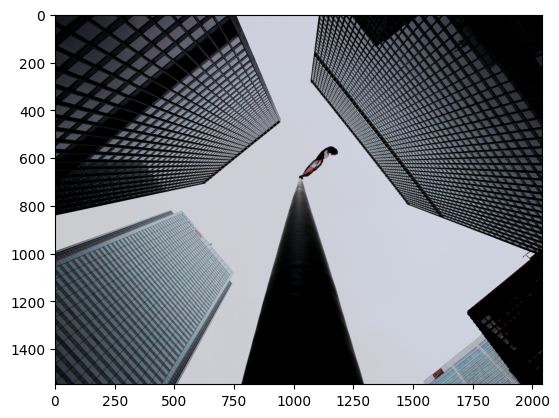

In [1]:
#@title Imports and Boilerplate

import urllib.request

import torch

import torch.nn as nn
import tqdm

import numpy as np
import cv2

import cv2
import imageio
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
from torch import nn
import matplotlib.pyplot as plt

def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor

def get_image():
    # image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
    # img = imageio.imread(image_url)[..., :3] / 255.
    # c = [img.shape[0] // 2, img.shape[1] // 2]
    # r = 256
    # img = img[c[0] - r:c[0] + r, c[1] - r:c[1] + r]
    image_path = '/home/yinqiang/yzw/datasets/div_bad_25_100/0188.png'
    # Reading the image from the local filesystem
    img = imageio.imread(image_path)[..., :3] / 255.
    c = [img.shape[0]//2, img.shape[1]//2]
    r = 512
    # img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
    return img
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
def get_psnr(img, output):
    block_original = img
    block_processed = output
    psnr_value = psnr(block_original, block_processed, data_range=255)

    return psnr_value
def save_img(generated, save_dir):
    from torchvision.utils import save_image
    import os
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 保存图像，这里仅保存批量中的第一个图像作为示例
    save_path = os.path.join(save_dir, "generated_image.png")
    save_image(generated[0], save_path)

    print(f"Generated image saved to {save_path}")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# Get an image that will be the target for our model.
target = torch.tensor(get_image()).unsqueeze(0).permute(0, 3, 1, 2).to(device)
plt.imshow(tensor_to_numpy(target[0]))
plt.show()

# Create input pixel coordinates in the unit square. This will be the input to the model.
coords_x = np.linspace(0, 1, target.shape[3], endpoint=False)
coords_y = np.linspace(0, 1, target.shape[2], endpoint=False)
xy_grid = np.stack(np.meshgrid(coords_x, coords_y), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

from math import log2
class Embedder(nn.Module):
    def __init__(self, num_freqs, scale):
        super(Embedder, self).__init__()
        self.num_freqs = num_freqs
        self.scale = scale
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = 2
        out_dim = 0
        if False:
            embed_fns.append(lambda x : x)
            out_dim += d
            
        max_freq = log2(self.scale)
        N_freqs = self.num_freqs
        

        freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)

        for freq in freq_bands:
            for p_fn in [torch.sin, torch.cos]:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(2*torch.pi* x * freq))
                out_dim += d
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def forward(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], 1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from matplotlib.image import imread

def apply_log_linear_bandpass_filter(image, max_len):
    """
    对图像应用对数线性分段的带通滤波器。
    """
    rows, cols = image.shape[:2]
    center_row, center_col = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((X - center_col)**2 + (Y - center_row)**2)
    
    max_distance = np.sqrt(center_row**2 + center_col**2)

    
    # 计算对数线性的分段边界
    log_distances = np.linspace(0, np.log(max_distance), max_len+1)
    freq_list = []
    coefficient_tensor = []
    for i in range(max_len):
        inner_radius = np.exp(log_distances[i])
        outer_radius = np.exp(log_distances[i + 1])
        freq_avg = (inner_radius + outer_radius)/2
        freq_list.append(freq_avg)
        bandpass_filter = np.logical_and(distance_from_center >= inner_radius, distance_from_center < outer_radius)
        filtered_channels = 0
        for c in range(image.shape[2]):
            channel = image[:, :, c]       
            fft_result = fft2(channel)
            fft_shifted = fftshift(fft_result)   
            fft_filtered = fft_shifted * bandpass_filter  
            channel_filtered = ifft2(ifftshift(fft_filtered)).real
            filtered_channels+=channel_filtered
        filtered_channels[filtered_channels!=0.]=1. 
        coefficient_tensor.append(filtered_channels)

    return torch.tensor(coefficient_tensor).to("cuda:1"), freq_list

In [5]:
import torch
import torch.nn as nn
from numpy import log2
from torch.utils.data import Dataset, DataLoader
import torch
class CoordinateDataset(Dataset):
    def __init__(self, coordinate_tensor, freq_list):
        """
        coordinate_tensor: 形状为 [1, 2, H, W] 的张量，
                           其中 coordinate_tensor[0, 0, :, :] 表示 x 坐标，
                           coordinate_tensor[0, 1, :, :] 表示 y 坐标。
        """
        self.coordinate_tensor = coordinate_tensor.to("cpu")
      
        self.freq_bands = freq_list
        self.height = coordinate_tensor.size(2)
        self.width = coordinate_tensor.size(3)
    
    def __len__(self):
        # 数据集的总长度等于所有可能的坐标点数
        return self.height * self.width
    
    def __getitem__(self, idx):
        # 将一维索引转换为二维坐标位置
        y_idx = idx // self.width
        x_idx = idx % self.width
        
        # 获取对应的坐标值
        x_coordinate = int(self.coordinate_tensor[0, 0, y_idx, x_idx].item()*self.width)
        y_coordinate = int(self.coordinate_tensor[0, 1, y_idx, x_idx].item()*self.height)
        embed_fns = []
    
        for freq in self.freq_bands:
            for p_fn in [torch.sin, torch.cos]:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(2 * torch.pi * x * freq))
        
        return torch.cat([fn(self.coordinate_tensor[0][:,y_coordinate,x_coordinate]) for fn in embed_fns]),x_coordinate, y_coordinate

class PositionalEncoder(nn.Module):
    def __init__(self, num_freqs, image_path = '/home/yinqiang/fourier-feature-networks/0188.png'):
        super(PositionalEncoder, self).__init__()
        image = imread(image_path)  # 归一化图像
        c = [image.shape[0]//2, image.shape[1]//2]
        r = 512
        # image = image[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
        self.num_freqs = num_freqs
        self.coefficient_tensor, self.freq_list = apply_log_linear_bandpass_filter(image, num_freqs)

    def forward(self, inputs):
        # 假设inputs是一个N*2的tensor，其中N是点的数量，2代表x和y坐标
        print("starting")
        encoded = torch.zeros(1, self.num_freqs*4, inputs.shape[2], inputs.shape[3]).to("cuda:1")
        dataset = CoordinateDataset(inputs, self.freq_list)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=10)  # 根据需要设置 batch_size
        print(encoded[0,self.num_freqs:self.num_freqs*2,:,:].shape)
        print(self.coefficient_tensor.shape)
        for coordinates in tqdm(dataloader):
               encoded[0,:,coordinates[2],coordinates[1]] = coordinates[0].to("cuda:1").T
        encoded[0,:self.num_freqs,:,:] = encoded[0,:self.num_freqs,:,:] * self.coefficient_tensor
        encoded[0,self.num_freqs:self.num_freqs*2,:,:] = encoded[0,self.num_freqs:self.num_freqs*2,:,:] * self.coefficient_tensor
        encoded[0,self.num_freqs*2:self.num_freqs*3,:,:] = encoded[0,self.num_freqs*2:self.num_freqs*3,:,:] * self.coefficient_tensor
        encoded[0,self.num_freqs*3:,:,:] = encoded[0,self.num_freqs*3:,:,:] * self.coefficient_tensor
        print("finished")        
        return encoded

In [6]:
model = nn.Sequential(
        nn.Conv2d(
            128,
            256,
            kernel_size=1,
            padding=0,
            bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0,
            bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            3,
            kernel_size=1,
            padding=0,
            bias=False),
        nn.Sigmoid(),

    ).to(device)

# Note: this can be done outside of the training loop, since the result at this stage is unchanged during the course of training.
x = PositionalEncoder(32)(xy_grid)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

for epoch in tqdm(range(10000)):
    optimizer.zero_grad()

    generated = model(x)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(tensor_to_numpy(target[0]))
      ax1.set_title('GT')  # 设置子图的标题
      ax2.imshow(tensor_to_numpy(generated[0]))
      ax2.set_title('Recon')  # 设置子图的标题
      
      plt.show()
      target_np = tensor_to_numpy(target[0])
      generated_np = tensor_to_numpy(generated[0])
      print("psnr for upper block is ", get_psnr(target_np[0:256, 0:256], generated_np[0:256, 0:256]))
      height, width, _ = target_np.shape
      print("psnr for lower block is ", get_psnr(target_np[height-256:height, width-256:width], generated_np[height-256:height, width-256:width]))  
      print("psnr for whole image is ", get_psnr(target_np, generated_np))
    if epoch == 9999:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(tensor_to_numpy(target[0]))
      ax1.set_title('GT')  # 设置子图的标题
      ax2.imshow(tensor_to_numpy(generated[0]))
      ax2.set_title('Recon')  # 设置子图的标题
      
      plt.show()
      target_np = tensor_to_numpy(target[0])
      generated_np = tensor_to_numpy(generated[0])
      print("psnr for upper block is ", get_psnr(target_np[0:256, 0:256], generated_np[0:256, 0:256]))
      height, width, _ = target_np.shape
      print("psnr for lower block is ", get_psnr(target_np[height-256:height, width-256:width], generated_np[height-256:height, width-256:width]))  
      print("psnr for whole image is ", get_psnr(target_np, generated_np))
      save_img(generated, save_dir = "/home/yinqiang/fourier-feature-networks/Result_188/FFT_BP_woC_len32_BF")

starting
torch.Size([32, 1548, 2040])
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..

  0%|          | 0/24672 [00:00<?, ?it/s]

KeyboardInterrupt: 